In [20]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('..')

import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from matplotlib import pyplot as plt

from get_data import get_data, get_splitted_data
from models.active_model import ActiveLearningExperiment
from models.strategy import *
from models.utils import ObstructedY

from get_data import _split

from misc.config import c
data_dir = c["DATA_DIR"]

import kaggle_ninja

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Prepare super simple dataset, but already a good visualization for strategy behavior

def get_splitted_uniform_data(n_folds, seed, valid_size):
    X = np.random.uniform(-1, 1, size=(3000, 2))
    y = np.ones(X.shape[0])
    negative_examples = np.where(X[:, 0] < 0)
    y[negative_examples] = -1
    return X, y

X, y = get_splitted_uniform_data(n_folds=3, seed=777, valid_size=0.15)

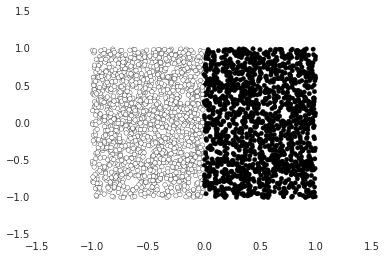

In [22]:
%matplotlib inline
plt.scatter(X[:,0], X[:,1], c=y)

In [23]:
# ObstructedY is a class that deals with logic of unseen samples

y_obstructed = ObstructedY(y)
y_obstructed.query(np.random.choice(range(X.shape[0]), 100, replace=False))

array([-1.,  1.,  1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,
        1.,  1., -1.,  1.,  1., -1.,  1., -1., -1.,  1.,  1., -1.,  1.,
       -1., -1., -1.,  1., -1.,  1., -1., -1., -1.,  1., -1., -1., -1.,
       -1., -1., -1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,  1., -1.,
       -1., -1.,  1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1.,
        1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,
        1.,  1., -1., -1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [24]:
y_obstructed.known_ids

array([  57,   59,   85,  150,  158,  174,  225,  231,  248,  257,  258,
        274,  276,  288,  301,  303,  348,  355,  362,  395,  441,  454,
        478,  554,  561,  564,  660,  690,  734,  736,  779,  783,  852,
        890,  927,  949,  992, 1020, 1021, 1036, 1073, 1104, 1106, 1112,
       1172, 1175, 1232, 1238, 1288, 1314, 1326, 1376, 1387, 1408, 1452,
       1485, 1541, 1550, 1579, 1704, 1716, 1820, 1822, 1825, 1885, 1895,
       1899, 1926, 1945, 1972, 2072, 2074, 2086, 2115, 2129, 2132, 2176,
       2256, 2283, 2311, 2323, 2355, 2375, 2376, 2381, 2400, 2413, 2449,
       2463, 2515, 2632, 2697, 2721, 2776, 2779, 2819, 2834, 2859, 2872,
       2922])

In [25]:
al = ActiveLearningExperiment(strategy=uncertainty_sampling, base_model_cls=SVC, batch_size=20,
                              param_grid = {"C":[10e-2, 1, 10e2]}, metrics=[wac_score])

In [26]:
# For basic strategies this will work, for more complex we will have to refactor code 
# (more complex are chen_krause for instance)
# you can see strategies in misc/strategy.py

al.fit(X, y_obstructed, test_error_datasets=[("xyz", [X, y])])

2015-07-05 08:34:20,594 - al_ecml2015 - INFO - Running Active Learninig Experiment for approximately 146 iterations
2015-07-05 08:34:20,594 - al_ecml2015 - INFO - Logging concept error every iteration
2015-07-05 08:34:20,595 - al_ecml2015 - INFO - Warm start size: 100
2015-07-05 08:34:20,614 - al_ecml2015 - INFO - Iter: 1, labeled 100/3000
2015-07-05 08:34:20,667 - al_ecml2015 - INFO - Iter: 2, labeled 120/3000
2015-07-05 08:34:20,700 - al_ecml2015 - INFO - Iter: 3, labeled 140/3000
2015-07-05 08:34:20,739 - al_ecml2015 - INFO - Iter: 4, labeled 160/3000
2015-07-05 08:34:20,784 - al_ecml2015 - INFO - Iter: 5, labeled 180/3000
2015-07-05 08:34:20,831 - al_ecml2015 - INFO - Iter: 6, labeled 200/3000
2015-07-05 08:34:20,897 - al_ecml2015 - INFO - Iter: 7, labeled 220/3000
2015-07-05 08:34:20,945 - al_ecml2015 - INFO - Iter: 8, labeled 240/3000
2015-07-05 08:34:20,999 - al_ecml2015 - INFO - Iter: 9, labeled 260/3000
2015-07-05 08:34:21,064 - al_ecml2015 - INFO - Iter: 10, labeled 280/3000


In [29]:
import seaborn

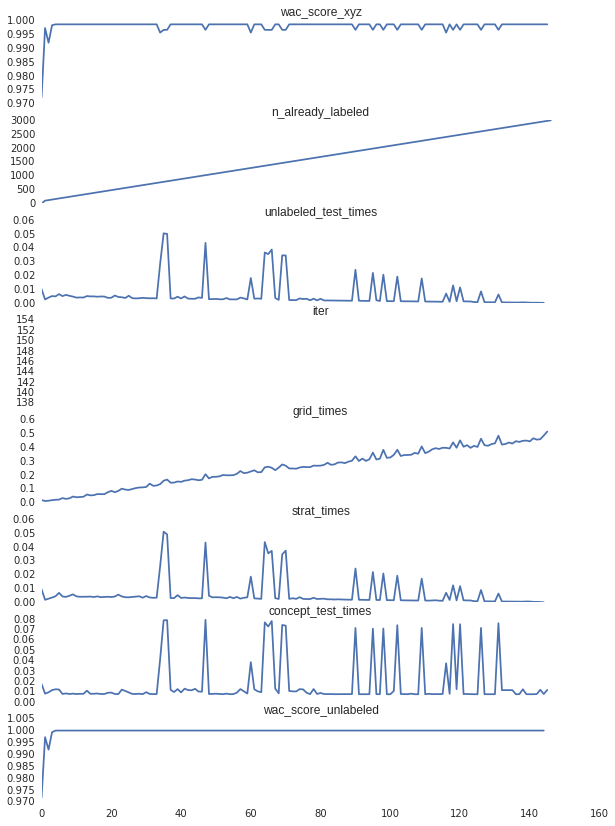

In [34]:
# Active Learning Experiments has some stuff to plot. 

fig, ax = plt.subplots(nrows=len(al.monitors), ncols=1, sharex=True)

fig.set_figheight(14)
fig.set_figwidth(10)

for (title, values), axes in zip(al.monitors.iteritems(), ax):
    axes.plot(values)
    axes.set_title(title)
plt.show()

In [ ]:
# So in general ActiveLearningExperiment is like GridSearchCV - it is a meta model. scikit-learn has some 
# similar classes (like mentioned GridSearchCV) and we can base on them